# Milestone 2 - Data collection and description
The second task is to intimately acquaint yourself with the data, preprocess it and complete all the necessary descriptive statistics tasks. We expect you to have a pipeline in place, fully documented in a notebook, and show us that you’ve advanced with your understanding of the project goals by updating its README description.

In [125]:
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
import json
import seaborn as sns
import bisect
from IPython.display import IFrame
%matplotlib inline

In [2]:
import findspark
findspark.init()

import pyspark
conf = pyspark.SparkConf()\
    .setMaster('local[*]')\
    .set('spark.executor.memory', '2g')\
    .set('spark.driver.memory', '2g')\
    .set('spark.executor.instances', '4')
    
sc = pyspark.SparkContext(conf=conf)

# Gaining insight into the Amazon product network 

## Overview

The Amazon dataset contains relations among products, such as "also viewed", "also bought", "bought together", "bought after viewing". These links can be used to create a graph that represents products with similar characteristics, that is, products that are viewed together but not bought together.
Our idea is to exploit the dataset in order to create clusters of competing products. These clusters may be used not only to identify the best product in terms of rating and sales within a group, but also to investigate how brands can influence the sales and the prices of similar products.

The dataset is transformed into a graph of relations between products, where the vertices represent products, and edges represent competition between products. For instance, if two products are viewed together (people who viewed product A also viewed product B, and vice versa) but not bought together, they are competitors. On the other hand, two products that are viewed together and bought together are not competitors (e.g. a user buys a smartphone and a cover). A way of expressing this in more formal terms is with max-cliques, that is, finding sets of vertices that are totally interconnected.

## Dataset description

The Amazon dataset consists of two JSON files: 
- *metadata.json*: contains information about the products, such as their unique ID, description and price. The size of the dataset is 9.81 GB (uncompressed, in JSON format).
- *reviews.json*: contains reviews and ratings associated with each product, as well as the helpfulness of each review. The size of the dataset is approximately 87 GB (again, uncompressed and in JSON format).

Since the dataset does not fit in memory, we cannot process it using libraries such as Pandas, unless we reduce its size first.
Therefore, the initial data processing was carried out using **PySpark**, both on the cluster (especially for the reviews dataset) and in local. While it may seem inappropriate at first, using Spark in local makes sense for medium-sized datasets (like the metadata one), as it automatically parallelizes jobs using all cores, and spills to disk intermediate results that cannot fit in main memory.

### Metadata
The dataset contains a list of entries of products with the following fields (some of them may be missing):
- **asin**: unique ID of the product.
- **title**: name of the product.
- **price**: price in US dollars.
- **imUrl**: URL of the product image.
- **related**: related products, which contains the sub-lists: *also bought, also viewed, bought together, buy after viewing*.
- **salesRank**: sales rank information, i.e. how well the product compares to other products in the same category in terms of sales.
- **brand**: brand name.
- **categories**: the category(-ies) to which the product belongs.

These fields are already sufficient for building our graph, since they contain the above-mentioned relations between products, as well as their IDs and names. Here we present an example of such a record:

In [12]:
sc.textFile('data/metadata.json')\
    .map(lambda x: ast.literal_eval(x))\
    .filter(lambda x: 'price' in x and 'related' in x)\
    .take(1)

[{'asin': '0000143561',
  'categories': [['Movies & TV', 'Movies']],
  'description': '3Pack DVD set - Italian Classics, Parties and Holidays.',
  'imUrl': 'http://g-ecx.images-amazon.com/images/G/01/x-site/icons/no-img-sm._CB192198896_.gif',
  'price': 12.99,
  'related': {'also_viewed': ['B0036FO6SI',
    'B000KL8ODE',
    '000014357X',
    'B0037718RC',
    'B002I5GNVU',
    'B000RBU4BM'],
   'buy_after_viewing': ['B0036FO6SI',
    'B000KL8ODE',
    '000014357X',
    'B0037718RC']},
  'salesRank': {'Movies & TV': 376041},
  'title': 'Everyday Italian (with Giada de Laurentiis), Volume 1 (3 Pack): Italian Classics, Parties, Holidays'}]

Note that we had to use `ast.literal_eval` instead of the JSON library because the dataset is not in standard JSON format. It appears to be in Python's `print() ` format.

Before moving forward, we have to decide whether it makes sense to carry out our analysis on the whole dataset, or if it is more appropriate to select only a subset of all categories. It turns out that the latter is the case: sales in categories such as **Music**, **Books**, or **Clothes** depend on people's personal preferences, and are less (if not at all) prone to competition. On the contrary, electronic products are the ones that are subject to real competition, as clients wants to get the best possible product at the lowest cost. Moreover, this selection step allows us to reduce the size of the dataset and process it more efficiently.

Therefore, the first step consists in listing all categories and selecting those in which we are interested. As can be seen from the example above, categories are represented as hierarchies, e.g. `["Sports & Outdoors", "Other Sports", "Dance"]` means that the product can be found in the category **Sports & Outdoors -> Other Sports -> Dance**. Firstly, we extract the list of macro-categories (top-level categories such as **Sports & Outdoors**) along with their product count, and we inspect them manually. Our goal is to choose macro-categories containing products that can be objectively compared in terms of features and characteristics, such as *Electronics* or *Cell phones*. Converseley, categories of which the purchase decision is subjective (e.g. clothes and books) are discarded.

In [13]:
# Get all top-level categories along with their product count
categories_macro = sc.textFile('data/metadata.json')\
    .map(lambda x: ast.literal_eval(x))\
    .filter(lambda x: 'categories' in x)\
    .flatMap(lambda x: x['categories'])\
    .map(lambda x: x[0])\
    .map(lambda x: (x, 1))\
    .reduceByKey(lambda x, y: x + y)\
    .collect()

In [19]:
# We show the top categories sorted by product count
df = pd.DataFrame(categories_macro)
df.columns = ['category', 'count']
df.sort_values('count', ascending=False).head(30)

,category,count
49,"Clothing, Shoes & Jewelry",3429257
13,Books,2855617
66,CDs & Vinyl,1523001
30,Kindle Store,1088341
72,Sports & Outdoors,543514
73,Electronics,500600
52,Home & Kitchen,437019
32,Cell Phones & Accessories,357693
36,Toys & Games,336460
9,Automotive,331484


According to our considerations, we decided to include the following macro categories in our analysis: **Electronics**, **Cell Phones & Accessories**, **Automotive**, **Tools & Home Improvement**, and **Musical Instruments**. The choice is motivated both by their sizes and by the fact that they represent products that are comparable.

Now, we want to have a more detailed description of the categories. Therefore, for each macro-category, we convert the category lists within each product to a tree. We do this in a distributed way, using Spark. The job works as follows:
- **Map phase:** each list is converted to a tree. For instance:

In [120]:
# Transforms a category list into a flat tree (a tree with a linked list topology)
def convert_to_tree(elements):
    root = {}
    node = root
    for element in elements:
        node[element] = (1, {}) # Tuple: (product count, children)
        node = node[element][1]
    return root

In [121]:
convert_to_tree(["Sports & Outdoors", "Other Sports", "Dance"])

{'Sports & Outdoors': (1, {'Other Sports': (1, {'Dance': (1, {})})})}

Each category includes the product count along with its subcategories (children). The product count within a category includes the sum of the product counts of all its children.

- **Reduce phase:** all trees are merged together recursively, creating a huge category tree that reflects the entire dataset.

In [122]:
# Merge nodes
def merge_trees(a, b):
    for key in b:
        if key in a:
            a[key] = (a[key][0] + b[key][0], a[key][1])
            merge_trees(a[key][1], b[key][1])
        else:
            a[key] = b[key]
    return a

In [123]:
# Example
a = convert_to_tree(["Sports & Outdoors", "Other Sports", "Dance"])
b = convert_to_tree(["Sports & Outdoors", "Supplies"])
merge_trees(a, b)

{'Sports & Outdoors': (2,
  {'Other Sports': (1, {'Dance': (1, {})}), 'Supplies': (1, {})})}

Now we run the actual job on Spark.

In [39]:
# Top-level categories of interest
categories_to_extract = set(['Electronics', 'Cell Phones & Accessories', 'Automotive',\
                             'Tools & Home Improvement', 'Musical Instruments'])

# Build the category tree
category_tree = sc.textFile('data/metadata.json')\
    .map(lambda x: ast.literal_eval(x))\
    .filter(lambda x: 'categories' in x)\
    .flatMap(lambda x: x['categories'])\
    .filter(lambda x: x[0] in categories_to_extract)\
    .map(convert_to_tree)\
    .reduce(merge_trees)

In the example below, the subtree of *Cell Phones & Accessories* is shown, along with product count for each sub-category. As can be seen, sub categories may differ significantly in terms of belonging products. Therefore, some heuristics may be necessary to group together categories that contains a small number of products.

In [33]:
# Each node represents a (count, children) tuple
category_tree['Cell Phones & Accessories']

(357693,
 {'Accessories': (109763,
   {'Accessory Kits': (26545, {}),
    'Audio Adapters': (497, {}),
    'Batteries': (9882,
     {'Battery Charger Cases': (560, {}),
      'External Battery Packs': (2079, {}),
      'Internal Batteries': (6651, {})}),
    'Bluetooth Speakers': (782, {}),
    'Car Accessories': (5863,
     {'Car Cradles & Mounts': (4705,
       {'Car Cradles': (424, {}), 'Car Mounts': (4189, {})}),
      'Car Kits': (845, {}),
      'Car Speakerphones': (312, {})}),
    'Chargers': (17463,
     {'Car Chargers': (7650, {}),
      'Cell Phone Docks': (1894, {}),
      'International Chargers': (169, {}),
      'Solar Chargers': (284, {}),
      'Travel Chargers': (7122, {})}),
    'Cradles, Mounts & Stands': (48, {'Stands': (47, {})}),
    'Data Cables': (6671, {}),
    'Headsets': (10197,
     {'Bluetooth Headsets': (5066, {}), 'Wired Headsets': (5023, {})}),
    'Phone Charms': (3073, {}),
    'Replacement Parts': (6592, {}),
    'SIM Cards & Tools': (506, {}),
    '

We made an interactive visualization using the 5 macro-categories that we selected. This allowed us to explore the tree and see its overall structure, as the number of sub-categories is too high for being inspected textually.

In [135]:
IFrame('https://niccolosacchi.github.io/categories-graph.html', width=800, height=650)

### Reviews

The reviews dataset (`reviews.json`) has a size of approximately 87 GB. Each review contains the following fields:
- **reviewerID**: unique ID associated to each user.
- **asin**: unique ID associated to each product.
- **reviewerName**: name of the user.
- **helpful**: helpfulness rating of the review (tuple of 2 elements: "A out of B find this review helpful").
- **reviewText**: text of the review.
- **overall**: rating of the product from 1 to 5 stars.
- **summary** - summary of the review.
- **unixReviewTime** - unix timestamp of the review.
- **reviewTime** - raw timestamp of the review.

Since our project is mainly focused on products, we are not interested in *individual* reviews. However, we still need this dataset in order to compute the aggregate ratings for each product and merge them into our dataset.

## Preliminary processing

#### Reduce the Amazon dataset

Due to the large size of the Amazon dataset, we decided to create a custom dataset prior to performing any further analysis. The custom dataset, which has been named *reduced*, contains only products belonging to the macro-categories selected in the previous parapraph. In addition, the review ratings of each product are averaged and merged with the products. As a result, we obtain a smaller *metadata* dataset (1.71 GB) that is enriched with the average product rating field, as well as with the reviews count and their helpfulness.

##### Aggregate ratings
The average product rating is computed from the data in the *reviews* dataset. For each entry, the product ID and the rating are stored, respectively, in the *asin* and *overall* fields. To compute the rating, entries are grouped by product ID and then 
averaged on the *overall* field. In addition to the average rating for each product, we add some extra information which might come handy later: the number of reviews (`num_reviews`), and the ratio of helpful reviews (`helpful_fraction`).
The output is saved in JSON format as `aggregate_ratings.json`. The code for processing the data (shown below) was executed on the ADA cluster.

```python
import json
import pyspark.sql.functions as func
from pyspark import SparkContext
from pyspark.sql import SQLContext

sc = SparkContext()
sqlContext = SQLContext(sc)

rdd = sc.textFile('/datasets/productGraph/complete.json')\
    .map(lambda x: json.loads(x))\
    .map(lambda x: (x['asin'], x['overall'], x['helpful'][0], x['helpful'][1]))

sqlContext.createDataFrame(rdd, ['asin', 'overall', 'helpful_positive', 'helpful_all'])\
    .groupBy('asin')\
    .agg(
        func.mean('overall').alias('average_rating'),
        func.count('overall').alias('num_reviews'),
        (func.sum('helpful_positive') / func.sum('helpful_all')).alias('helpful_fraction')
    )\
    .toJSON()\
    .saveAsTextFile('aggregate_ratings.json')
```

##### Merge the datasets
*Metadata* is filtered so as to mantain only the products belonging to the macro categories of interest, which are then merged with *aggregate_ratings*. The code that generates the *reduced* dataset is shown below. An important observation is that a product can belong to multiple categories (`categories` is a list of lists). However, in our merging process, we need to assign a product to only one category to avoid duplicates. After some investigation, we decided to empirically re-assign products only to the first one in order of appearance, as often the other ones were the result of crawling errors or were inappropriate.

```python
# The list of macro categories that we want to extract
categories_to_extract = set(['Electronics', 'Cell Phones & Accessories', 'Automotive',\
                             'Tools & Home Improvement', 'Musical Instruments'])

# Extract macro category and delete img url to reduce size
def extract_category(x):
    x['category'] = x['categories'][0]
    del x['categories']
    x['num_reviews'] = 0 # The number of reviews is 0 in the default case
    if 'imUrl' in x:
        del x['imUrl'] # Delete image URL to save space
    return x

# Load the aggregate ratings
ratings = sc.textFile('data/aggregate_ratings.json')\
    .map(lambda x: json.loads(x))\
    .map(lambda x: (x['asin'], x))

# Filter products and merge datasets.
# Note that we use the left outer join, so as to include products that have no reviews.
sc.textFile('data/metadata.json')\
    .map(lambda x: ast.literal_eval(x))\
    .filter(lambda x: 'categories' in x)\
    .map(extract_category)\
    .filter(lambda x: x['category'][0] in categories_to_extract)\
    .map(lambda x: (x['asin'], x))\
    .leftOuterJoin(ratings)\
    .map(lambda x: x[1])\
    .map(lambda x: x[0] if x[1] == None else {**x[0], **x[1]})\
    .map(lambda x: json.dumps(x))\
    .saveAsTextFile('data/reduced.json')
```

##  Exploratory data analysis

### Missing data statistics
As first thing, we want to see which fields can be missing, and, should they be, the actual fraction of missing values. In order to do this, we sample a subset of the dataset (25%) using Spark, and we process it with Pandas. This will not affect the result considerably, as the sampled dataset is still huge.

In [79]:
sample = sc.textFile('data/reduced.json')\
    .sample(fraction=0.25, withReplacement=False)\
    .map(lambda x: json.loads(x))\
    .collect()

In [80]:
df = pd.DataFrame(sample)
df.head()

,asin,average_rating,brand,category,description,helpful_fraction,num_reviews,price,related,salesRank,title
0,7506343215,5.000000,Disney,"[Tools & Home Improvement, Painting Supplies &...",World Best Quality Wall Art Decoration Point S...,NaN,3,20.97,"{'also_bought': ['B009TO0J8G', 'B0081W4ICA', '...",NaN,Disney Finding Nemo Kids' Room/Nursery Vinyl W...
1,9881976561,1.000000,NaN,"[Cell Phones & Accessories, Cases, Basic Cases]",NaN,NaN,1,NaN,NaN,{'Cell Phones & Accessories': 920073},HTC Radar 4G (T-Mobile) White Flowers Design H...
2,9989375887,5.000000,NaN,"[Cell Phones & Accessories, Accessories, Charg...",Professional Retractable Car Charger for your ...,NaN,1,16.49,"{'buy_after_viewing': ['9989376565', 'B006SMFU...",{'Cell Phones & Accessories': 566475},Professional Retractable Car Charger for your ...
3,B00002230Y,4.166667,NaN,"[Tools & Home Improvement, Power & Hand Tools,...",The DeWalt DW7440 table saw stand delivers the...,0.727273,6,63.11,"{'also_viewed': ['B000J46C18', 'B0019VKEM8', '...",NaN,DEWALT DW7440 Table Saw Stand
4,B0000225UJ,4.352941,Freud,"[Tools & Home Improvement, Power & Hand Tools,...",Ideal for hard- and softwood as well as stacks...,0.872727,17,35.97,"{'also_bought': ['B00004T78V', 'B00006XMTU', '...",NaN,Freud LU82M010 10-Inch 60 Tooth TCG Crosscutti...


asin                0.000000
average_rating      0.000008
brand               0.625386
category            0.000000
description         0.072881
helpful_fraction    0.504019
num_reviews         0.000000
price               0.178669
related             0.250299
salesRank           0.603602
title               0.009775
dtype: float64


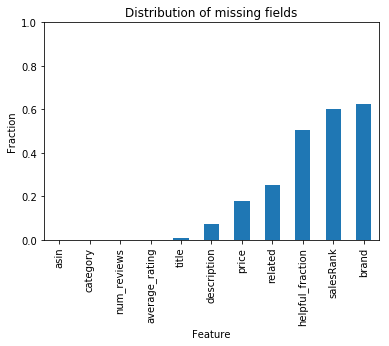

In [81]:
missing_stats = df.isnull().sum()/len(df)
print(missing_stats)
pd.DataFrame(missing_stats).sort_values(0).plot.bar(title="Distribution of missing fields", legend=None)
plt.ylim(0, 1)
plt.ylabel('Fraction')
_ = plt.xlabel('Feature')

The results are mixed:
- The ID (`asin`) and the categories are always present by definition.
- Almost all articles have at least one review (non-null `average_rating`).
- The title can be missing at times, although this is very rare.
- The price and textual description can be missing with a low probability.
- The sales rank and the brand are missing in most cases (about 60% of cases).

### Distributions of features
We now proceed by analyzing the statistics of numeric fields. This might give us some useful insights.

In [82]:
df.describe()

,average_rating,helpful_fraction,num_reviews,price
count,378205.000000,187584.000000,378208.000000,310634.000000
mean,3.951448,0.792250,14.032929,55.654890
std,1.148507,0.280449,103.705377,106.583985
min,1.000000,0.000000,0.000000,0.010000
25%,3.333333,0.681818,1.000000,7.950000
50%,4.200000,0.900000,2.000000,18.120000
75%,5.000000,1.000000,5.000000,50.990000
max,5.000000,1.000000,18294.000000,999.990000


From these basic statistics, we can observe that:
- The average ratings tend to be high.
- The distribution of the number of reviews for each article is heavy-tailed (the mean is much larger than the median).
- Most reviews are regarded as helpful (50% of the articles have an helpfulness percentage greater than 90%), meaning that we can take them into account with good confidence.

Additionally, we plot the distribution of the average ratings.

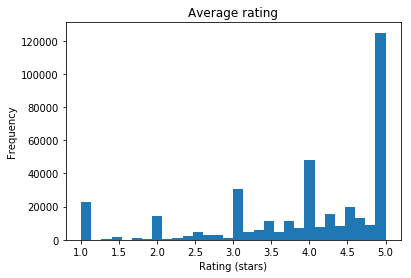

In [83]:
df['average_rating'].plot.hist(title='Average rating', bins=30)
plt.xlabel('Rating (stars)')

As can be seen from the histogram plot above, the ratings are concentrated near integer values. This is due to the fact that most articles contain a small number of reviews (in most cases, only one), and they strongly bias the distribution. Earlier, we observed that the distribution of the *number of reviews* feature is heavy-tailed. To illustrate this clearly, we plot it below.

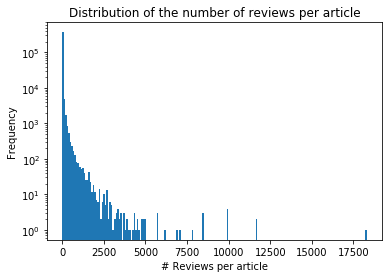

In [84]:
df['num_reviews'].plot.hist(bins=200, log=True, title='Distribution of the number of reviews per article')
plt.xlabel('# Reviews per article')

This indeed confirms our hypothesis. Note that we plotted our histogram in logarithmic scale. The majority of articles contain a very small number of reviews, but there are some outliers that are reviewed a huge number of times.

We plot again the histogram of the average rating per article, but this time we weigh each record according to the number of reviews of the corresponding record.

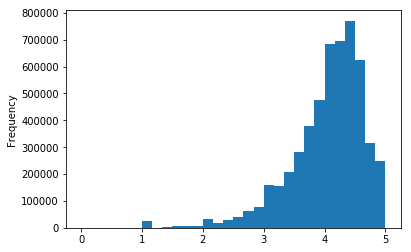

In [85]:
df['average_rating'].fillna(0).plot.hist(weights = df['num_reviews'], bins=30)

This result is much smoother and reflects reality. As can be seen, users tend to be very "generous" when reviewing products.

We also plot the distribution of the article prices:

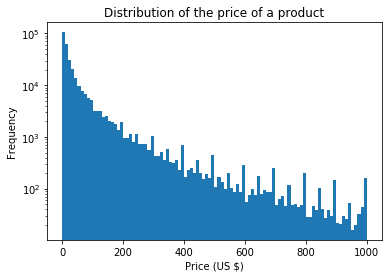

In [87]:
df['price'].plot.hist(bins=100, log=True, title='Distribution of the price of a product')
plt.xlabel('Price (US $)')

Again, we plotted the histogram in log-scale, which reveals that prices are as well distributed according to a heavy-tailed distribution. We can also observe another important detail: the price seems truncated to 1000 dollars (this is also reflected in the summary statistics, which show that the maximum price is 999.99). This seems to be wrong, as the real Amazon website shows products that are well above 1000 dollars as price.
To verify whether this is caused by some error in our analysis, we double-check this fact on the original, full dataset.

In [89]:
sc.textFile('data/metadata.json')\
    .map(lambda x: ast.literal_eval(x))\
    .filter(lambda x: 'price' in x and x['price'] > 999.99)\
    .count()

0

Our supposition was correct: the prices are truncated at 999.99 at the source.

### Correlation analysis
We perform some basic correlation analysis on the sampled dataset, without splitting the categories. Specifically, we investigate the correlations among price, review rating and sales rank, hoping to find some patterns in the distribution of these variables.

In [104]:
df_corr = df[df['num_reviews'] > 5] # We select only product with more than 5 reviews
df_corr = df_corr[['price', 'average_rating', 'salesRank']].dropna().sample(frac=0.1) # Sub-sample the data
df_corr['salesRank'] = df_corr['salesRank'].map(lambda x: next(iter(x.values())) if len(x) > 0 else np.nan)
df_corr = df_corr.dropna()

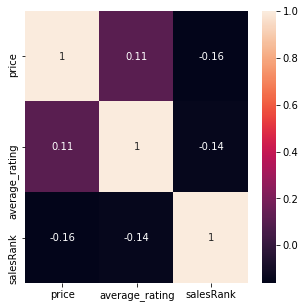

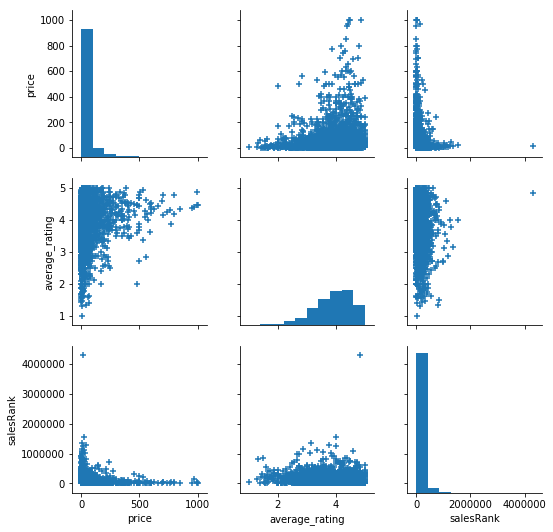

In [106]:
corr = df_corr.corr()
plt.figure(figsize=(5,5))
_ = sns.heatmap(corr, annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

sns.pairplot(df_corr, markers='+')

According to the graphs above, we discuss the following outcomes on the correlation analysis:
- The correlation coefficients do not seem to be significant. However, the plots show some trends:
 - As the price increases, the ratings tend to have lower variance and higher mean. In other words, more expensive products have on average higher ratings.
 - As the price increases, the sales rank tends to be lower (i.e. better). Costly products may be regarded as superior by people.

Of course, this analysis is superficial, as it is not subdivided by category. Nonetheless, it is interesting because it shows how people tend to think.

## Graph analysis
As we said at the beginning, one of our goals is to analyze competing products and gain useful insights. At this step of the project (Milestone 2) we do not reach a conclusion yet, but we aim at setting up a working pipeline and reinforce our hypothesis about the feasibility of the project.

For this pilot analysis, we focus on the *Headphones* subcategory. Generally speaking, in our future experiments we will carry out the study on each category independently (in an automated way). The reason for the subdivision is that:
- It does not make sense to compare products in different categories, although the graph may contain such links. In fact, we expect that such links would be of type *bought together* (e.g. a phone and a cover).
- The algorithms that we are going to use (e.g. max-cliques) are NP-Complete, and will surely benefit from a clever splitting of the data.

In [107]:
# Collect the products in the "Headphones" category
cat = ['Electronics', 'Accessories & Supplies', 'Audio & Video Accessories', 'Headphones']
records = sc.textFile('data/reduced.json')\
    .map(lambda x: json.loads(x))\
    .filter(lambda x: 'salesRank' in x and 'price' in x)\
    .filter(lambda x: len(x['category']) >= len(cat) and x['category'][:len(cat)] == cat)\
    .collect()

As a first pre-processing step, we build our graph data structure using an efficient layout: adjacency lists indexed by numbers, and not strings. This representation is suitable because the graph is sparse.

Going into more depth, the graph is constructed as follows:
- We add an edge from product A to product B if clients buy B after viewing A (direct competition).
- We remove an edge between A and B if A and B are frequently bought together (no competition).

In previous experiments, we tried to employ the *also_viewed* relation, with mixed results. This relation produces a graph that is too dense to give meaningful results. Additionally, we believe that the *also_viewed* relation is generated by Amazon's recommender system according to users' preferences, and does not actually represent a graph relation.

In [109]:
# Convert string IDs to numeric IDs
name_id_mapping = {}
for i, record in enumerate(records):
    name_id_mapping[record['asin']] = i
    
adj_list = []
adj_set = []
for record in records:
    # Buy after viewing: add edge
    if 'related' in record and 'buy_after_viewing' in record['related']:
        av = record['related']['buy_after_viewing']
    else:
        av = []
    av = list(filter(lambda x: x in name_id_mapping, av))
    adj_list.append(sorted(set([name_id_mapping[x] for x in av])))
    
    # Bought together: remove edge (if added earlier)
    if 'related' in record and 'bought_together' in record['related']:
        bt = record['related']['bought_together']
    else:
        bt = []
    bt = list(filter(lambda x: x in name_id_mapping, bt))
    bt = [name_id_mapping[x] for x in bt]
    for o in bt:
        if o in adj_list[-1]:
            adj_list[-1].remove(o)
    adj_set.append(frozenset(adj_list[-1]))

# Transposed adjacency list (represents the incoming edges in every node)
adj_list_incoming = []
for adj in adj_list:
    adj_list_incoming.append([])
    
for i, adj in enumerate(adj_list):
    for node in adj:
        adj_list_incoming[node].append(i)

# Food for thought (and material for future experiments)
### Fan-in/Fan-out analysis
A good indicator of a product success might be represented by its *fan-in* metric, that is, the number of incoming edges. If a product has many incoming edges, it means that people decide to buy it after comparing it with several other products.
Conversely, if a product has a large number of outgoing edges (*fan-out*), it might be an indicator that it is not a good product (or is too pricey). Probably, it would also make sense to compare the *fan-in* minus *fan-out* metric, but *not* the ratio.

In [111]:
fan_in = list(map(lambda x: len(x), adj_list_incoming))
fan_out = list(map(lambda x: len(x), adj_list))
df = pd.DataFrame()
df['fan_in'] = fan_in
df['fan_out'] = fan_out
df.index = pd.DataFrame(records)['asin']
df.sort_values('fan_in', ascending=False).head()

,fan_in,fan_out
asin,,
B00007E7C8,58,2
B004PNZFZ8,39,3
B001EZYMF4,30,3
B003EM8008,22,2
B000AJIF4E,16,2


Product **B00007E7C8** appears to be a pretty good product, as people buy it after coming from 58 other products.

### Clique analysis
This is one of the most important aspects of our project. A max-clique is a set of totally interconnected nodes, which, in our scenario, represent products that are in direct competition among each other (and it is not really clear which "wins"). Note that these competition relations might even comprehend products of the same brand: this could turn out to be an interesting tools for vendors.

Our algorithm for finding max-cliques is optimized for dealing with sparse graphs, and works as follows (by induction):
- A single node is always a valid 1-clique
- The current clique is incrementally expanded using a DFS, making sure that the max-clique condition is always satisfied. This is achieved by ensuring that the last inserted node is connected to all previous nodes, and vice versa.
- If the current clique is not a sub-clique of a larger clique, it is marked as a max-clique.

In [115]:
cliques = []
def extract_all_cliques(nodes, prev_list):
    count = 0
    m = 0 if len(prev_list) == 0 else bisect.bisect_right(nodes, prev_list[-1])
    for a in nodes[m:]:
        connected = True
        for test in prev_list:
            if test not in adj_set[a] or a not in adj_set[test]:
                connected = False
                break
        
        if connected:
            prev_list.append(a)
            if extract_all_cliques(adj_list[a], prev_list) == 0:
                cliques.append(prev_list.copy())
                count += 1
            prev_list.pop()
    return count

In [116]:
%timeit extract_all_cliques(range(len(adj_list)), [])

658 µs ± 4.59 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


As can be seen, the performance is very good if we keep the dataset size small by splitting categories.

In [117]:
cliques = []
print(extract_all_cliques(range(len(adj_list)), []), 'cliques found')

483 cliques found


We show some cliques of size 3:

In [124]:
for c in cliques:
    if len(c) < 3:
        continue
    for i in c:
        print('*',records[i]['title'], ' - $', records[i]['price'])
    print('------')

* Sennheiser CX 300 II Precision Enhanced Bass Earbuds (Black)  - $ 30.49
* Symphonized NRG Premium Genuine Wood In-ear Noise-isolating Headphones with Mic (White)  - $ 25.0
* New Original Gold Xiaomi 2nd Piston Earphone Ii Headphone Headset Earbud with Remote &amp; Mic for Smartphone  - $ 23.99
------
* Kidz Gear Wired Headphones For Kids - Green  - $ 21.99
* Kidz Gear Wired Headphones For Kids - Ltd. Edition White  - $ 19.99
* Kidz Gear Wired Headphones For Kids - Blue  - $ 20.99
------
* Sennheiser RS 170 Digital Wireless Headphone with Dynamic Bass and Surround Sound  - $ 189.95
* Sony MDRRF985RK Wireless RF Headphone, Black  - $ 73.95
* Sennheiser  RS120 On-Ear 926MHz Wireless RF Headphones with Charging Cradle  - $ 79.95
------
* Sennheiser HD201 Lightweight Over-Ear Binaural Headphones  - $ 24.95
* Sennheiser HD 202 II Professional Headphones (Black)  - $ 24.94
* Audio-Technica ATH-M20 Professional Studio Monitor Stereo Headphones  - $ 14.95
------


The result is indeed interesting. We can observe competing products of different brands, a well as competing products of the same brand. In some cases, the cliques represent the same product in different colors.

The important observation, here, is that these products present similar characteristics. For example, one of the groups shows competing *wireless headphones*, whereas another one shows binaural headphones.

Of course, we carried out this analysis on other categories as well (e.g. mobile phones), with similar results.

## Conclusion and future work

We can safely conclude that our project is feasible. The data seems to reflect our assumptions, and our pipeline allows us to process it in reasonable time.

Quoting the README, as a guideline until Milestone 3, we aim to accomplish the following goals:
- Investigate the cliques to gain useful insights, as defined in Milestone 1. In particular, we want to extract recurrent patterns from the graph.
- Obtain the best metric for evaluating a product, among average rating, sales rank, ingoing edges, or other potential metrics that we might discover in the future.
- Now that we have the pipeline in place, we could try to answer the open questions in the initial proposal.

From a technical perspective, the clique extraction algorithm will be automated so as to be performed on all categories (with a Spark job), and not just a sample category as we showed here (the category tree will assist us in this task). Finally, all cliques will be grouped and analyzed with the aim of finding correlations between the elements in them. For instance, a simple question might be: is the most sold product in a group also the cheapest? Or, more generally, can we predict the most preferred product in a group according to some features?